### Evaluation notebook for trained and saved models

In [9]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import numpy as np
import torch
from torch import nn
from mapsgan import SGANSolver, data_loader
from mapsgan.sgan import TrajectoryGenerator, TrajectoryDiscriminator
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from pathlib import Path
import os, glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0


In [2]:
torch.cuda.is_available()

True

### Set these manually according to the script

In [3]:
# can directly copy-paste from the script
mode = 'sgan'
fileprefix = '/cloud/sgan_1'
lr_gen = 1e-3
lr_dis = 1e-3

In [4]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
filesearch = root_path + '/models' + fileprefix + '*10000*' # can change here acc to saved epoch
filelist = glob.glob(filesearch)
filename = filelist[0]

In [5]:
filename

'/home/yy/ADL4CV/mapsgan/models/cloud/sgan_1_20190117-055507_epoch_10000'

### Initializing dataloader, models, solver

In [7]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.train_dir,
                                  shuffle=True)
_ , testloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.test_dir,
                                  shuffle=True)

In [10]:
generator = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)

discriminator = TrajectoryDiscriminator(obs_len=8,
                                        pred_len=12,
                                        embedding_dim=16,
                                        h_dim=64,
                                        mlp_dim=64,
                                        num_layers=1,
                                        dropout=0,
                                        batch_norm=0,
                                        d_type='local')

In [11]:
if mode == 'clr':
    solver = cLRSolver(generator, discriminator, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})
elif mode == 'cvae':
    solver = cVAESolver(generator, discriminator, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})
elif mode == 'sgan':
    solver = SGANSolver(generator, discriminator, experiment=experiment, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})

### Looking at losses

In [13]:
epochs = solver.load_checkpoint(filename)

Restoring from checkpoint


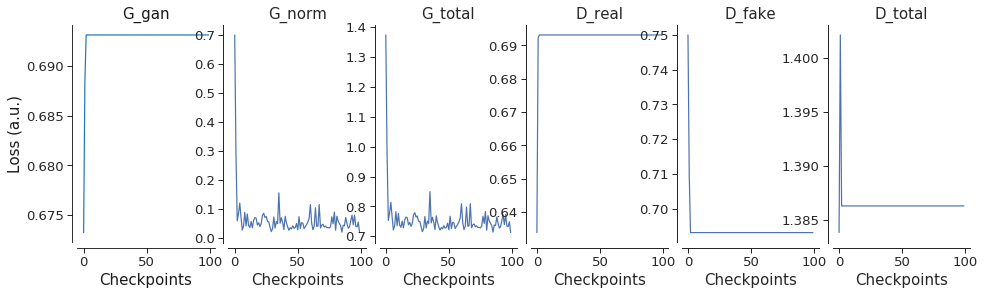

In [14]:
vis = Visualization()
vis.loss(solver.train_loss_history)

### Looking at predictions

In [15]:
output = solver.test(testloader, load_checkpoint_from=filename) #can also use trainloader for overfit

Loading from checkpoint


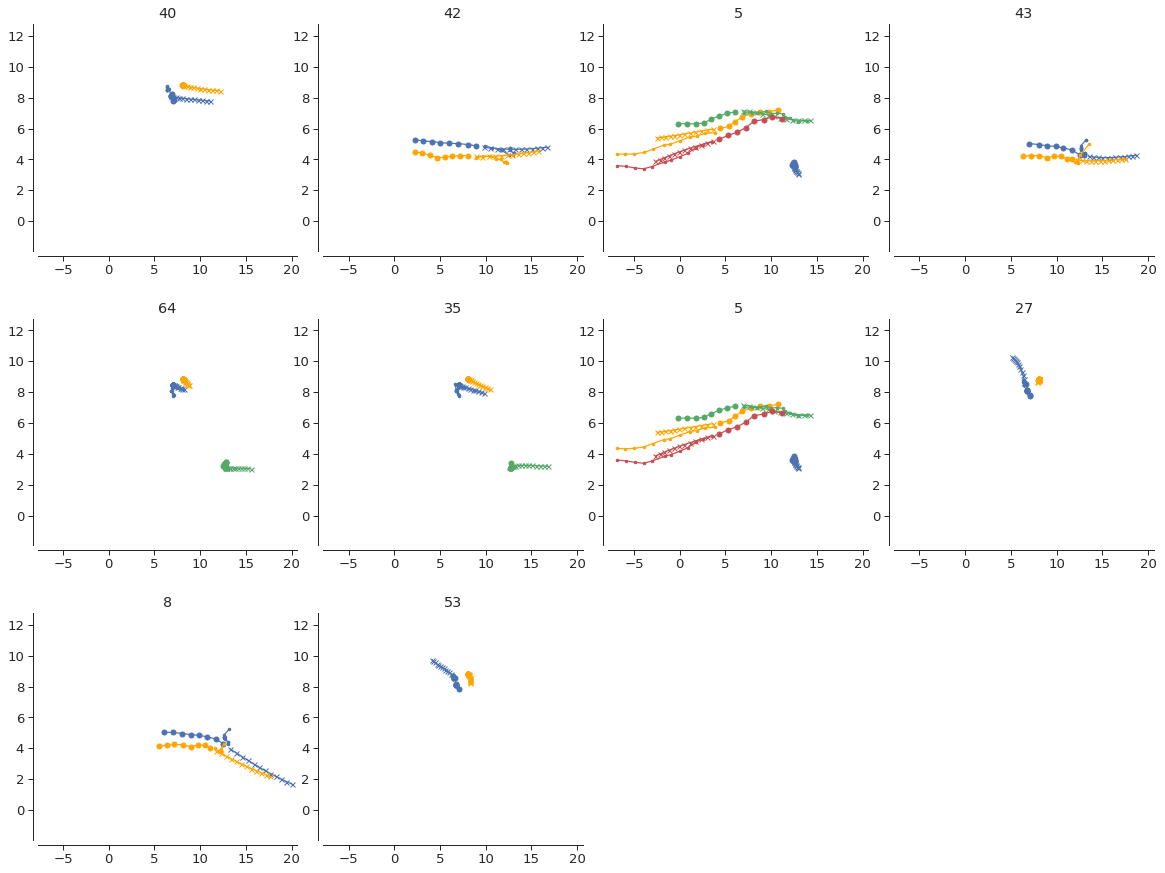

In [16]:
vis = Visualization()
ll = vis.trajectories(output, scenes=[10])